In [1]:

from default_parameters.lorenz63 import *
from ML_models.EchoStateNetwork import *
from essentials.create import create_ensemble

In [2]:

observe_idx = np.array([0, 1, 2])  # Number of dimensions the ESN prediction
bayesian_update = True

update_reservoir = 1
plot_training_data = 0
plot_timeseries_flag = 1


In [3]:

ESN_params = bias_params.copy()
dt_ESN = dt_model * ESN_params['upsample']

dt_DA = .25 * t_lyap
total_time = 20. * t_lyap
num_DA_steps = int(total_time / dt_DA)

t_ref = t_lyap


N_train = int(ESN_params['t_train'] / dt_ESN)
N_val = int(ESN_params['t_val'] / dt_ESN)
N_test = int(ESN_params['t_test'] / dt_ESN) * 20



In [4]:

forecast_params['model'] = Lorenz63
forecast_params['dt'] = dt_model

truth = Lorenz63(**forecast_params)

In [5]:
ESN_name = 'my_esn_partial'


train_model = create_ensemble(forecast_params, filter_params)
N_wtv_model = (N_train + N_val + ESN_params['N_wash'] * 2) * ESN_params['upsample']
N_test_model = N_test * ESN_params['upsample']
N_transient_model = int(train_model.t_transient / dt_model)
out = []
for Nt in [N_transient_model, N_wtv_model, N_test_model]:
    state, t1 = train_model.time_integrate(Nt)
    train_model.update_history(state, t1, reset=False)
    yy = train_model.get_observable_hist(Nt)
    out.append((yy, t1))
train_model.close()

rng = np.random.default_rng(0)


# Build training data dictionary
Y = train_model.get_observable_hist(N_wtv_model + N_test_model)
Y = Y.transpose(2, 0, 1)

# ESN class
ESN_case = EchoStateNetwork(Y[0, 0, :], dt=dt_model, **ESN_params)

# Train
ESN_train_data = dict(data=Y,
                      bayesian_update=bayesian_update,
                      observed_idx=observe_idx
                      )
ESN_case.train(**ESN_train_data)



 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 15 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-12	 -1.2133
2	 2.000e-01	 1.581e+00	 1.000e-06	 -1.1721
3	 2.000e-01	 5.000e+00	 1.000e-12	 -1.3179
4	 2.000e-01	 1.581e+01	 1.000e-09	 -1.0875
5	 2.000e-01	 5.000e+01	 1.000e-06	 1.1331
6	 3.500e-01	 5.000e-01	 1.000e-12	 -1.0623
7	 3.500e-01	 1.581e+00	 1.000e-06	 -1.1289
8	 3.500e-01	 5.000e+00	 1.000e-09	 -1.2508
9	 3.500e-01	 1.581e+01	 1.000e-09	 -0.9191
10	 3.500e-01	 5.000e+01	 1.000e-06	 3.0080
11	 5.000e-01	 5.000e-01	 1.000e-12	 -1.0445
12	 5.000e-01	 1.581e+00	 1.000e-06	 -1.2130
13	 5.000e-01	 5.000e+00	 1.000e-12	 -1.2331
14	 5.000e-01	 1.581e+01	 1.000e-09	 1.2766
15	 5.000e-01	 5.000e+01	 1.000e-06	 3.6310
16	 6.500e-01	 5.000e-01	 1.000e-06	 -0.9846
17	 6.500e-01	 1.581e+00	 1.000e-06	 -1.2218
18	 6.500e-01	 5.000e+00	 1.000e-12	 -1.2308
19	 6.500e-01	 1.581e+01	 1.000e-06	 0.7104
20	 6.500e-01	

In [6]:

observe_idx = np.array([0, 2])  
ESN_case.observed_idx = observe_idx

exec(open("../ML_models/EchoStateNetwork.py").read())



N_wash_model = ESN_case.N_wash * ESN_case.upsample
wash_model = ESN_train_data['data'][:, -N_wash_model:, ESN_case.observed_idx].transpose(1, 2, 0)

t_wash_model = np.arange(0, N_wash_model) * dt_model

wash_data, t_wash = wash_model[::ESN_case.upsample], t_wash_model[::ESN_case.upsample]

ESN_case.M = np.zeros([len(observe_idx), ESN_case.N_dim + ESN_case.N_units])

u_wash, r_wash = ESN_case.openLoop(wash_data)


(5, 2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)


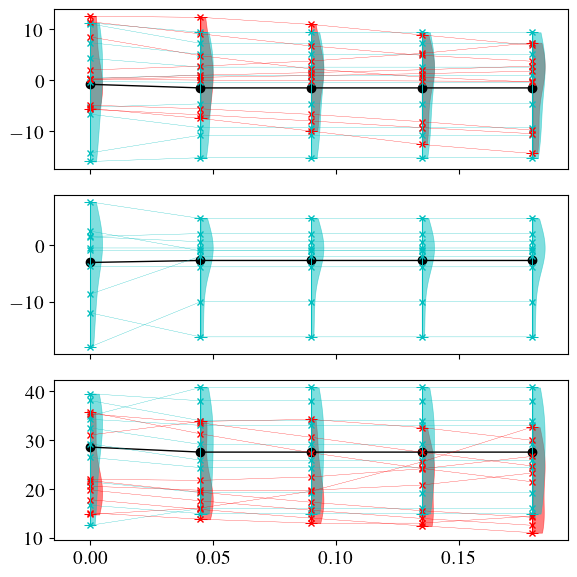

In [13]:


fig1 = plt.figure(figsize=(6, 6), layout="tight")
axs = fig1.subplots(nrows=ESN_case.N_dim, ncols=1, sharex='col', sharey='row')

from essentials.plotResults import plot_violins
# exec(open("../essentials/plotResults.py").read())
# plt.rc('text', usetex=True)
# plt.style.use('dark_background')

kk = -1
for dim_i in range(ESN_case.N_dim):
    axs[dim_i].plot(t_wash, np.mean(u_wash[:, dim_i], axis=-1), 'k-o', lw=1)
    axs[dim_i].plot(t_wash, u_wash[:, dim_i], 'c-x', lw=0.2, ms=4)
    if dim_i in observe_idx:
        kk += 1
        axs[dim_i].plot(t_wash, wash_data[:, kk], 'r-x', lw=0.2, ms=4)
        plot_violins(axs[dim_i], values=list(wash_data[:, kk, :]), location=t_wash, color='r', widths=0.01)
    plot_violins(axs[dim_i], values=list(u_wash[:, dim_i, :]), location=t_wash, color='c', widths=0.01)
    


In [8]:
num_tests = num_DA_steps
Nt_tests = int(dt_DA / dt_ESN)
Nt_tests_model = Nt_tests * ESN_case.upsample

N_wash_model = ESN_case.N_wash * ESN_case.upsample
wash_model = ESN_train_data['data'][:, -N_wash_model:, ESN_case.observed_idx].transpose(1, 2, 0)

t_wash_model = np.arange(0, N_wash_model) * dt_model

wash_data, t_wash = wash_model[::ESN_case.upsample], t_wash_model[::ESN_case.upsample]

u_wash, r_wash = ESN_case.openLoop(wash_data)

ESN_case.reset_state(u=u_wash[-1], r=r_wash[-1])

for Nt in [int(truth.t_transient/dt_model), N_wash_model]:
    truth.t = 0.
    psi, tt = truth.time_integrate(Nt)
    truth.update_history(psi, tt, reset=True)



(2, 53) (2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)
(2, 53) (2, 10)


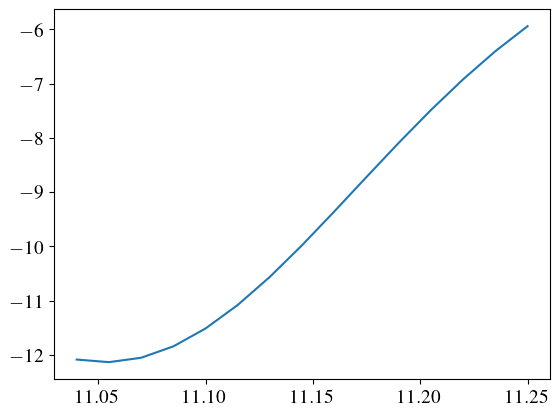

In [9]:
plt.plot(truth.hist_t, truth.hist[:, 0])

In [11]:

FORECAST, FORECAST_TIME, ANALYSIS, TRUTH, TRUTH_TIME = [], [], [], [], []


for jj in range(num_tests + 1):
    # Forecast model and ESN
    psi, tt = truth.time_integrate(Nt_tests_model)
    truth.update_history(psi, tt, reset=False)

    u_closed, r_closed = ESN_case.closedLoop(Nt_tests)
    u_closed, r_closed = u_closed[1:], r_closed[1:]

    tt_up = tt[::ESN_case.upsample].copy()

    if not Nt_tests_model % Nt_tests:
        u_closed[-1] = interpolate(tt_up, u_closed, tt[-1], method='linear')
        r_closed[-1] = interpolate(tt_up, r_closed, tt[-1], method='linear')
        tt_up[-1] = tt[-1].copy()
    ESN_case.reset_state(u=u_closed[-1], r=r_closed[-1])

    # Take measurement of the truth
    y_true = truth.get_observable_hist(Nt_tests_model)
    d = y_true[-1, observe_idx, 0]


    # Update ESN with analysis state
    u_hat, r_hat = ESN_case.reconstruct_state(observed_data=d, update_reservoir=True)
    ESN_case.reset_state(u=u_hat, r=r_hat)
    
    TRUTH.append(y_true)
    TRUTH_TIME.append(y_true)
    FORECAST.append(u_closed)
    FORECAST_TIME.append(tt_up)
    ANALYSIS.append(u_hat)
    

(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)
(2, 53) (2,)

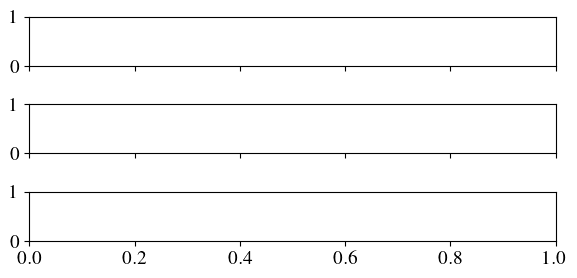

In [12]:

fig1 = plt.figure(figsize=(6, 3), layout="tight")
axs_test = fig1.subplots(nrows=ESN_case.N_dim, ncols=1, sharex='col', sharey='row')
